# Application of ResNet Cycle GAN on Style Transfer

Style transfer is a computer vision technique that "re-paint" the images with the visual style of another. Traditionally, machine learning models need a pair of images - a real photo and its artistic variation - to learn the styles and apply it to new photos. Nevertheless, it's very challenging and expensive to collect image pairs in real life. For instance, it's almost not possible to collect enough image pairs for model training to transfer the art styles of some famous artists to real photos. With the development of deep learning algorithms, a variation of generative adversarial networks (GAN) named CycleGAN has been designed to enable image-image translation and style transfer between unrelated images. In this study, a CycleGAN is implemented to transfer the art style of Monet to real photos. 300 Monet paintings and 7038 real photos are fed to CycleGAN to training the model. Each painting or image has 256 \times 256 pixels and 3 color channels. Photos applied with Monet style are evaluated with (MiFID) Memorization-informed Fréchet Inception Distance.

### Citation

Amy Jang, Ana Sofia Uzsoy, Phil Culliton. (2020). I’m Something of a Painter Myself. Kaggle. https://kaggle.com/competitions/gan-getting-started

## Exploratory Data Analysis

In [1]:
# import library
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
from PIL import Image
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Input, Conv2D, Conv2DTranspose, Dense, ReLU, LeakyReLU, Flatten, Dropout, BatchNormalization, Reshape, Activation, Concatenate
from tensorflow.keras.optimizers.legacy import Adam
from keras.models import Model
from tensorflow.keras.utils import plot_model
from google.colab import drive

!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-r7nikdm3
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-r7nikdm3
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


In [3]:
# Mount google drive and upload data
drive.mount('/gdrive', force_remount = True)
image_path = '/gdrive/MyDrive/week5_project/gan-getting-started.zip'
local_path = '/content'
!cp '{image_path}' .
os.chdir(local_path)
!unzip -q 'gan-getting-started.zip' -d '/content/images'

Mounted at /gdrive


In [4]:
# EDA
monet_painting_lst = os.listdir(os.path.join(local_path, 'images', 'monet_jpg'))
photo_lst = os.listdir(os.path.join(local_path, 'images', 'photo_jpg'))
print('Number of Monet images：', len(monet_painting_lst))
print('Number of photos：', len(photo_lst))

Number of Monet images： 300
Number of photos： 7038


In [5]:
# loading data
def loading_img(file_name_lst, folder_name):
    img_lst = []
    for file_name in file_name_lst:
        img_path = os.path.join(local_path, 'images', folder_name, file_name)
        img = Image.open(img_path)
        img = np.asarray(img) / 255.0
        img_lst.append(img)
    return np.array(img_lst)

painting_array = loading_img(monet_painting_lst, 'monet_jpg')
photo_array = loading_img(photo_lst, 'photo_jpg')

print('Dimension of painting array:', painting_array.shape, '\n'
      'Dimension of photo array:', photo_array.shape)

Dimension of painting array: (300, 256, 256, 3) 
Dimension of photo array: (7038, 256, 256, 3)


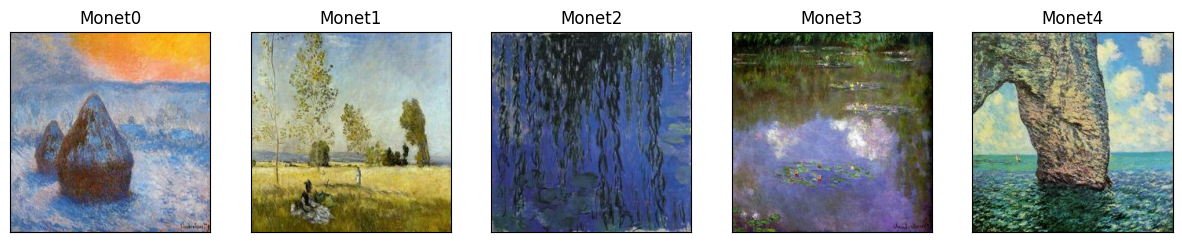

In [ ]:
# display images
random.seed(42)
def display_img(img_array, n_sample, title):
    f, ax = plt.subplots(1, n_sample, figsize = (15, 15))
    for i in range(n_sample):
        ind = random.randint(0, img_array.shape[0])
        img_rn = img_array[ind]
        ax[i].imshow(img_rn)
        ax[i].title.set_text(title + str(i))
        ax[i].set_xticks([])
        ax[i].set_yticks([])

display_img(painting_array, 5, 'Monet')

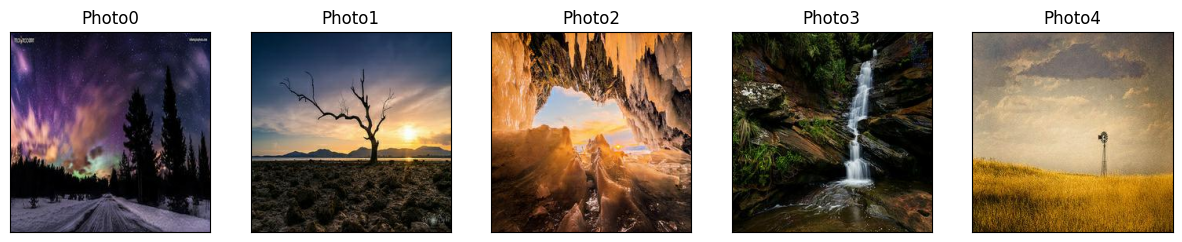

In [ ]:
random.seed(42)
display_img(photo_array, 5, 'Photo')

Five Monet paintings and five real photos are painted to gain the basic understanding of our training data. Both Monet paintings and photos have different contents, colors, contrasts, etc. from each other respectively. Each image has 256X256 pixels and three-color channels. To achieve a higher computational efficiency, they are all scaled down to 1X1 squared images.

## CycleGAN

CycleGAN is a deep learning algorithm developed for image-to-image translation tasks without the need for paired data. The model simultaneously train two generators and discriminators and uses cycle consistency loss to overcome the challenge of missing paired images. Two adversary loss (generator loss, discriminator loss) and identity loss will also be calculated during the training process. Identity loss is introduced to regularize the generator such that the output image will have the expected style if the input image is already stylized. Theoretically, a deeper neural network is expected to have a better performance. However, this is not always the case in practice and gradient might vanishes by passing through multiple layers. In this study, a skip connection approach named ResNet will be implemented between encoders and decoders to preserve the information that might be lost.

In [6]:
# Autoencoder
def downsample(filters, size, apply_instancenorm=True):
    init = tf.random_normal_initializer(0., 0.02)
    model = keras.Sequential()
    model.add(Conv2D(filters, size, strides=2, padding='same',kernel_initializer=init, use_bias=False))

    if apply_instancenorm:
        model.add(InstanceNormalization(axis = -1))

    model.add(LeakyReLU(alpha = 0.2))

    return model

def upsample(filters, size, apply_dropout=False):
    init = tf.random_normal_initializer(0., 0.02)

    model = keras.Sequential()
    model.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=init, use_bias=False))
    model.add(InstanceNormalization(axis = -1))

    if apply_dropout:
        model.add(Dropout(0.5))

    model.add(ReLU())

    return model

In [7]:
# Residual block
def resnet_block(input_layer, n_filters):
	init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

	model = Conv2D(n_filters, (4,4), padding='same', kernel_initializer=init)(input_layer)
	model = InstanceNormalization(axis=-1)(model)
	model = Activation('relu')(model)
	model = Conv2D(n_filters, (4,4), padding='same', kernel_initializer=init)(model)
	model = InstanceNormalization(axis=-1)(model)
	model = Concatenate()([model, input_layer])

	return model

In [8]:
# Generator
def define_generator(n_resnet = 9):
    input_img = keras.layers.Input(shape = [256, 256, 3])
    model = downsample(64, 4, apply_instancenorm=False)(input_img) # (bs, 128, 128, 64)
    model = downsample(128, 4)(model) # (bs, 64, 64, 128)
    model = downsample(256, 4)(model) # (bs, 32, 32, 256)

    for _ in range(n_resnet):
        model = resnet_block(model, 256)

    up1 = upsample(128, 4, apply_dropout = True)(model) #(bs, 64, 64)
    up2 = upsample(64, 4, apply_dropout = True)(up1) #(bs, 128, 128)

    init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    output = Conv2DTranspose(3, kernel_size = 4, strides = 2, padding='same', kernel_initializer=init)(up2)
    output = InstanceNormalization(axis=-1)(output)
    output_img = Activation('tanh')(output)

    model = Model(input_img, output_img)
    return model

In [9]:
# discriminator
def define_discriminator():
    input_img = keras.layers.Input(shape = [256, 256, 3])
    model = downsample(64, 4, apply_instancenorm=False)(input_img)
    model = downsample(128, 4)(model)
    model = downsample(256, 4)(model)

    init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    model = Conv2D(512, 3, padding='same', kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    output_patch = Conv2D(1, 3, padding='same', kernel_initializer=init)(model)

    model = Model(input_img, output_patch)
    return model

In [10]:
monet_generator = define_generator()
photo_generator = define_generator()
monet_discriminator = define_discriminator()
photo_discriminator = define_discriminator()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [11]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [16]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5


def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [17]:
# training model
monet_generator_opt1 = Adam(2e-5, beta_1=0.5)
photo_generator_opt1 = Adam(2e-5, beta_1=0.5)

monet_discriminator_opt1 = Adam(2e-5, beta_1=0.5)
photo_discriminator_opt1 = Adam(2e-5, beta_1=0.5)

cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_opt1,
    p_gen_optimizer = photo_generator_opt1,
    m_disc_optimizer = monet_discriminator_opt1,
    p_disc_optimizer = photo_discriminator_opt1,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

In [18]:
# loading data
painting_data = keras.utils.image_dataset_from_directory(
    directory = os.path.join(local_path, 'images', 'monet_jpg'),
    label_mode = None,
    image_size = (256, 256),
    batch_size = 8
)
painting_data = painting_data.map(lambda x: x/255.0)

photo_data = keras.utils.image_dataset_from_directory(
    directory = os.path.join(local_path, 'images', 'photo_jpg'),
    label_mode = None,
    image_size = (256, 256),
    batch_size = 8
)
photo_data = photo_data.map(lambda x: x/255.0)

Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.


In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((painting_data, photo_data)),
    epochs=3
)

Epoch 1/3
37/38 [============================>.] - ETA: 2s - monet_gen_loss: 10.0042 - photo_gen_loss: 9.6545 - monet_disc_loss: 0.6785 - photo_disc_loss: 0.6804

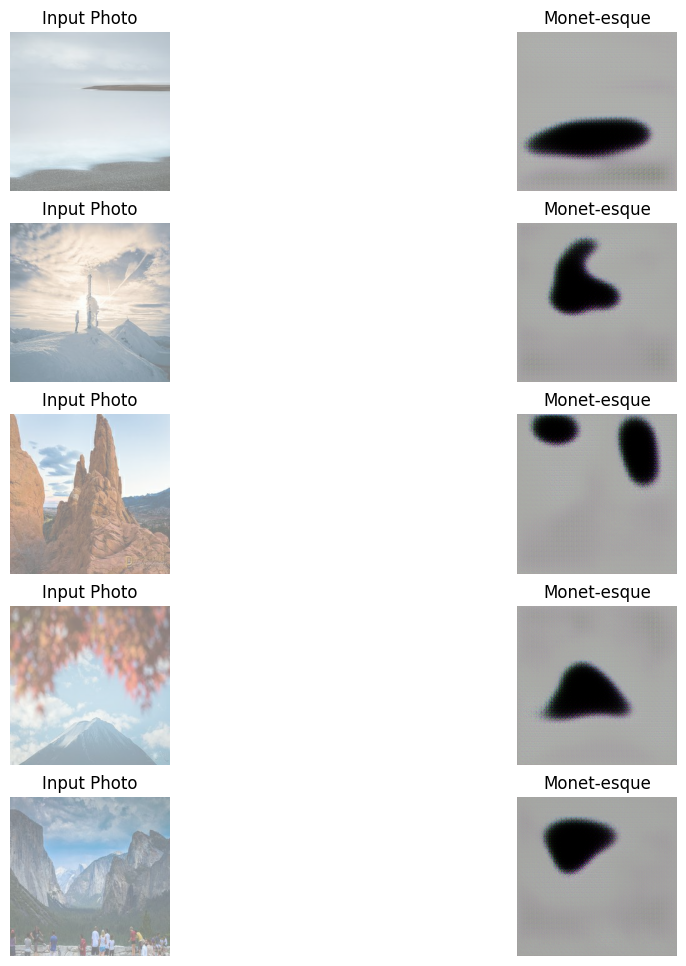

In [20]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_data.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [27]:
import PIL
i = 1
for img in photo_data:
    pred = monet_generator(img, training=False)[0].numpy()
    pred = (pred * 255.0).astype(np.uint8)
    img = PIL.Image.fromarray(pred)
    img.save(os.path.join(local_path, 'pred', str(i) + '.jpg'))
    i += 1